## Product Pricer Model

A model that estimates how much something costs.

### Baseline Models

In [ ]:
!pip install pandas numpy scikit-learn gensim huggingface-hub

In [1]:
### General Imports
import os
import math
import json
import random
from dotenv import load_dotenv
import matplotlib.pyplot as plt 
import pickle 
from collections import Counter
from huggingface_hub import login

/Volumes/VTG/Dev/C_5/Projects/week6/data_curation-optimization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Imports For Traditional Machine Learning

import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
### For NLP related machine learning

from sklearn.feature_extraction.text import CountVectorizer 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
### More of machine learning related ones
from sklearn.svm import LinearSVR 
from sklearn.ensemble import RandomForestRegressor 

In [5]:
### Internal Classes

from items import Item

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [6]:
### Constants -- used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"green": GREEN, "orange": YELLOW, "red": RED} 

In [7]:
### Environment 

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN_KEY = os.getenv("HF_TOKEN")

login(HF_TOKEN_KEY)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
%matplotlib inline

## Loading the pkl files

In [9]:
with open("train.pkl", "rb") as f:
    train = pickle.load(f)

with open("test.pkl", "rb") as f:
    test = pickle.load(f)

In [10]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Sydney Rustic Mirror - Vanity Mirror, Bathroom Mirror, Farmhouse Decor, Wood Mirror, Large Mirror - 4 Sizes & 20 Colors - Red Oak
The Sydney low profile thin wood framed mirror will blend effortlessly in your current decor creating a simple yet sophisticated look. Our mirror features a reclaimed rustic styled wood finish, strong decorative lines with a thin 2.25” inch wide frame maximizing the visible mirror. This hanging mirror can be mounted horizontally or vertically. Available in 20 Colors - Shown in Red Oak. Not sure on color we do color samples please contact us for details. Available in 4 sizes, 24x30, 36x30, 42x30 & 60x30, all measurements are overall dimensions including frame and mirror. We offer two types

Price is $


In [11]:
print(test[0].price)

189.99


## Tester Class

In [25]:
class Tester: 

    def __init__(self, predictor, title=None, data=test, size=250): 
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.truths = []
        self.guesses = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth): 
        if error < 20 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4: 
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i): 
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) < 40 else datapoint.title[:40] + "..."
        self.truths.append(truth)
        self.guesses.append(guess)
        self.errors.append(error) 
        self.sles.append(sle) 
        self.colors.append(color) 
        print(f"{COLOR_MAP[color]}{i + 1}: Guess: ${guess:,.2f} | Truth: ${truth:,.2f} | Error: {error:,.2f} | SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title): 
        max_error = max(self.errors) 
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color="deepskyblue", lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val) 
        plt.title(title)
        plt.show()

    def report(self): 
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color == "green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits / self.size * 100:.1f}%"
        self.chart(title)

    def run(self):
        for i in range(self.size): 
            self.run_datapoint(i) 
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()


In [26]:
### Simulator function

def random_pricer(item): 
    return random.randrange(1, 1000)

1: Guess: $655.00 | Truth: $189.99 | Error: 465.01 | SLE: 1.52 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $115.00 | Truth: $64.45 | Error: 50.55 | SLE: 0.33 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $26.00 | Truth: $128.99 | Error: 102.99 | SLE: 2.47 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $760.00 | Truth: $252.70 | Error: 507.30 | SLE: 1.21 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $282.00 | Truth: $16.99 | Error: 265.01 | SLE: 7.59 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $251.00 | Truth: $499.99 | Error: 248.99 | SLE: 0.47 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $229.00 | Truth: $363.36 | Error: 134.36 | SLE: 0.21 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $143.00 | Truth: $24.75 | Error: 118.25 | SLE: 2.96 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $755.00 | Truth: $65.20 | Error: 689.80 | SLE: 5.93 Item: Knitter's Pride Bamboo Knitting N

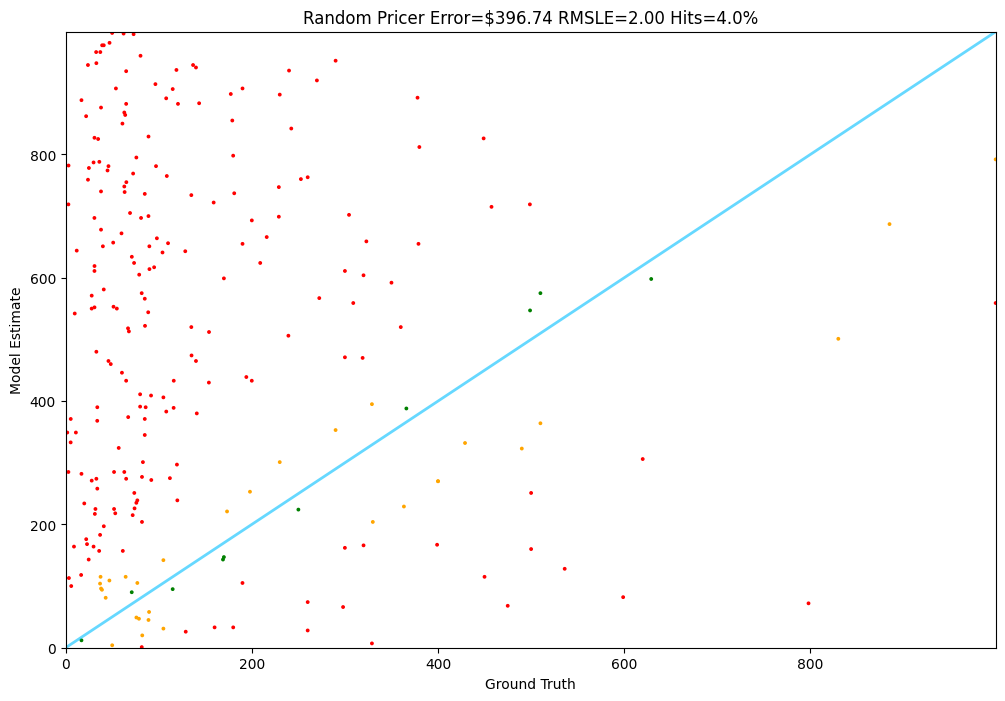

In [29]:
random.seed(42)

### Run Tester with a simulating guess
Tester.test(random_pricer)
